## Grad CAM

In [1]:
import sys,os,h5py
import matplotlib.pyplot as plt
import numpy as np 
from argparse import Namespace

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

sys.path.append(os.path.dirname(os.getcwd())) #add parent folder to PATH
import lib.models as models
import seqlogo
from IPython.display import  display

In [2]:
test = np.load('../data/Processed/test.npz')
# X_test = torch.tensor(test['arr_0'][:])
x_sample = torch.tensor(test['arr_0'][:1]).long()
x_sample.shape

torch.Size([1, 1000])

In [3]:
class Experiment(pl.LightningModule):
    def __init__(self,model):
        super(Experiment, self).__init__()
        self.model = model

In [4]:
hparams = {'emb': {'vocab_size':4, 'd_emb':64},
           'resnet': {'n_res_blocks':6, 'res_k':0, 'res_p':0.01, 
                      'block_stride':[2,1]*3,'C':32,'d':4},
           'seq_model_name': 'BiLSTM', 
           'seq_model': {'d_model':512,'p':0.01},
           'lin': {'skip_cnt':False, 'fc_h_dim':512, 'lin_p':0.01},
           'train': {'bs':25, 'batch_acum':4},
           'optim_name':'torch.optim.AdamW',
           'optim':{'lr':1e-4,'betas':(0.5,0.999),'weight_decay':0}
          }
chpt_path = '../data/lightning_logs/version_34/checkpoints/_ckpt_epoch_5.ckpt'

In [5]:
seq_model = eval('models.'+ hparams['seq_model_name'])(**hparams['seq_model'])
model = models.ResSeqLin(**hparams['emb'], seq_model=seq_model, 
                         **hparams['resnet'], **hparams['lin'])

hparams['n_params'] = model.summary()
exp = Experiment(model)
exp.load_state_dict(torch.load(chpt_path)['state_dict'])
model.eval()

Model parameters:				
Resnet part:	3406k
Sequence part:	4330k
Linear part:	33240k
Total:		41105k


ResSeqLin(
  (emb): Embedding(4, 64)
  (emb_ln): LayerNorm((1000, 64), eps=1e-05, elementwise_affine=True)
  (res): Resnet1D(
    (layers): Sequential(
      (0): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
      (1): ResBlock1D(
        (cvbn1): ConvBN(
          (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (cv): Conv1d(64, 256, kernel_size=(1,), stride=(2,), bias=False)
        )
        (cvbn2): ConvBN(
          (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (cv): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,), groups=32, bias=False)
        )
        (cvbn3): ConvBN(
          (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (cv): Conv1d(256, 128, kernel_size=(1,), stride=(1,), bias=False)
          (drop): Dropout2d(p=0.01, inplace=False)
        )
        (SE): SEblock(
          (fc1): Line

In [11]:
for i in model.modules():
    print(i)

ResSeqLin(
  (emb): Embedding(4, 64)
  (emb_ln): LayerNorm((1000, 64), eps=1e-05, elementwise_affine=True)
  (res): Resnet1D(
    (layers): Sequential(
      (0): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
      (1): ResBlock1D(
        (cvbn1): ConvBN(
          (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (cv): Conv1d(64, 256, kernel_size=(1,), stride=(2,), bias=False)
        )
        (cvbn2): ConvBN(
          (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (cv): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,), groups=32, bias=False)
        )
        (cvbn3): ConvBN(
          (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (cv): Conv1d(256, 128, kernel_size=(1,), stride=(1,), bias=False)
          (drop): Dropout2d(p=0.01, inplace=False)
        )
        (SE): SEblock(
          (fc1): Line

In [14]:
model._modules.items()

odict_items([('emb', Embedding(4, 64)), ('emb_ln', LayerNorm((1000, 64), eps=1e-05, elementwise_affine=True)), ('res', Resnet1D(
  (layers): Sequential(
    (0): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
    (1): ResBlock1D(
      (cvbn1): ConvBN(
        (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (cv): Conv1d(64, 256, kernel_size=(1,), stride=(2,), bias=False)
      )
      (cvbn2): ConvBN(
        (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (cv): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,), groups=32, bias=False)
      )
      (cvbn3): ConvBN(
        (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (cv): Conv1d(256, 128, kernel_size=(1,), stride=(1,), bias=False)
        (drop): Dropout2d(p=0.01, inplace=False)
      )
      (SE): SEblock(
        (fc1): Linear(in_features=128, out_features=

In [18]:
for module in model.named_modules():
    print(module)
    break

('', ResSeqLin(
  (emb): Embedding(4, 64)
  (emb_ln): LayerNorm((1000, 64), eps=1e-05, elementwise_affine=True)
  (res): Resnet1D(
    (layers): Sequential(
      (0): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
      (1): ResBlock1D(
        (cvbn1): ConvBN(
          (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (cv): Conv1d(64, 256, kernel_size=(1,), stride=(2,), bias=False)
        )
        (cvbn2): ConvBN(
          (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (cv): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,), groups=32, bias=False)
        )
        (cvbn3): ConvBN(
          (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (cv): Conv1d(256, 128, kernel_size=(1,), stride=(1,), bias=False)
          (drop): Dropout2d(p=0.01, inplace=False)
        )
        (SE): SEblock(
          (fc1):

In [6]:
def plot_seq(seq,title=None):
    ''' Arguments:
        seq: (seq_len,)
    '''
    r=1000//seq.shape[0]
    seq = seq[None,:]
    extended = np.repeat(np.repeat(seq,r,1),50,0)
    fig, ax = plt.subplots(figsize=(16,16))
    ax.get_yaxis().set_ticks([])
    ax.set_title(title)
    ax.imshow(extended,alpha=0.6,cmap='magma')
    
def arr2seq(arr):
    bases = ('A','G','C','T')
    sample = []
    for i in arr:
        sample.append(bases[i])
    return sample   

def relu_tensor(x): return F.relu(torch.tensor(x))

In [7]:
# Layer to visualize the activations from
last_cv = model.res.layers[-1] # for hight lvl features
first_cv = model.res.layers[0] #for motifs
ly = last_cv

global saved_acts
global saves_grads

def save_activations(module, input, output):
    global saved_acts
    saved_acts = output

def save_gradients(module, grad_input, grad_output):
    global saves_grads
    saves_grads = grad_output[0] #grads are tuples

    
fwd_handle = ly.register_forward_hook(save_activations)
bwd_handle = ly.register_backward_hook(save_gradients)

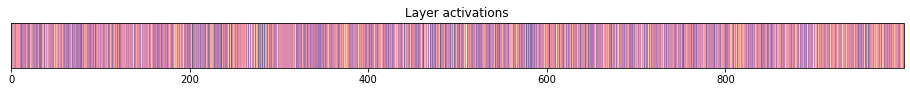

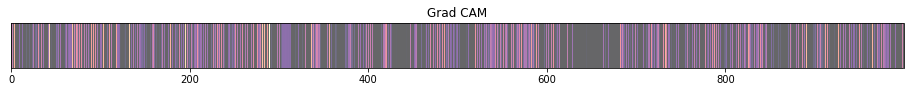

In [8]:
# Forward pass
y_hat = model(x_sample)
y_pred = torch.sigmoid(y_hat[0])
# print(saved_acts.shape)

# Mean of the activation of every filter for every class
act_avg = saved_acts[0].mean(0).detach().numpy()
plot_seq(act_avg,'Layer activations')

# We choose the class with highest probability, can be a choosen label
_, i = y_pred.topk(1)
# i=33
y_hat[0][:,i].backward()
# print(saved_acts[0].shape, saves_grads[0].shape)

alpha_c = saves_grads[0].mean(1,keepdim=True) #weight factor for every filter according to gradients, represent how much affect the choosen class
grad_cam = F.relu((alpha_c*saved_acts[0]).sum(0)).detach().numpy() #Grad-CAM over every filter
# print(alpha_c.shape, grad_cam.shape)

plot_seq(grad_cam,'Grad CAM')

In [9]:
#avg motif:
#take every input of size kernel size
ks = ly.kernel_size[0]
pad = torch.tensor([-1]*(ks//2))[None]
pad_sample = torch.cat((pad,x_sample,pad),dim=1)

positions = torch.zeros(grad_cam.shape[0],ks).fill_(-1) # -1 for padding
for i in range(grad_cam.shape[0]):
    positions[i] = pad_sample[0,i:i+ks]

def plot_PWM(acts):
    # count bases for each postion of ks and weight with grad cam
    pos_weight_counts = np.zeros((5,ks))
    for c in range(ks):
        for n in range(-1,4):
            weight_counts = acts[positions[:,c]==n].sum()
            pos_weight_counts[n+1,c] = weight_counts
            
    # PWM graph
#     fig,ax = plt.subplots()
#     ax.matshow(pos_weight_counts)
#     ax.set_yticklabels(['']+['PAD','A','G','C','T'])
#     plt.show()
    p = (pos_weight_counts[1:]/pos_weight_counts[1:].sum(0))
    ppm = seqlogo.Ppm(p)
    return seqlogo.seqlogo(ppm, ic_scale = False, format = 'svg', size = 'small')

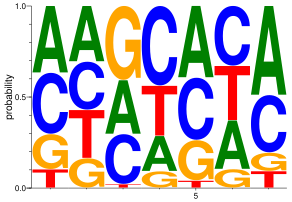

In [10]:
plot_PWM(grad_cam)

In [58]:
wgt_filter_acts = (alpha_c*saved_acts[0])
wgt_filter_acts_avg = wgt_filter_acts.mean(1)
wgt_filter_acts_avg.topk(64)

torch.return_types.topk(
values=tensor([ 1.4121e-04,  1.1433e-04,  7.7679e-05,  7.1446e-05,  6.8176e-05,
         6.6318e-05,  6.4378e-05,  5.5567e-05,  4.5311e-05,  3.8727e-05,
         3.6571e-05,  3.0820e-05,  3.0150e-05,  2.5427e-05,  2.4207e-05,
         2.1193e-05,  1.9516e-05,  1.8532e-05,  1.8218e-05,  1.6868e-05,
         1.4087e-05,  1.2563e-05,  1.1630e-05,  6.9817e-06,  5.5851e-06,
         3.8590e-06,  2.8253e-06,  2.5141e-06,  1.8961e-06,  1.6111e-06,
         1.4896e-06, -3.6039e-07, -1.4405e-06, -1.7496e-06, -2.7815e-06,
        -3.6419e-06, -4.7637e-06, -6.4298e-06, -6.8669e-06, -7.2498e-06,
        -7.4718e-06, -1.2225e-05, -1.2244e-05, -1.2397e-05, -1.2851e-05,
        -1.5907e-05, -1.7603e-05, -2.0753e-05, -2.1773e-05, -2.5839e-05,
        -2.6055e-05, -2.6450e-05, -2.8274e-05, -4.5955e-05, -5.8272e-05,
        -6.6030e-05, -7.0985e-05, -7.5018e-05, -8.1071e-05, -1.1238e-04,
        -1.1418e-04, -1.3216e-04, -1.3788e-04, -1.7948e-04],
       grad_fn=<TopkBackward>),

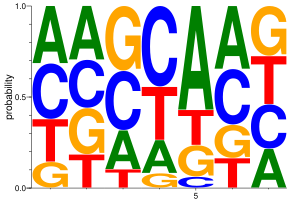

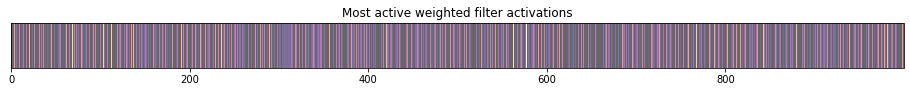

In [59]:
#best filter motif:
id_mif = wgt_filter_acts_avg.topk(1)[1].item() # most important filter for the class
filter_acts = wgt_filter_acts[id_mif].detach().numpy()
filter_acts = relu_tensor(filter_acts)
plot_seq(filter_acts,'Most active weighted filter activations')
plot_PWM(filter_acts)

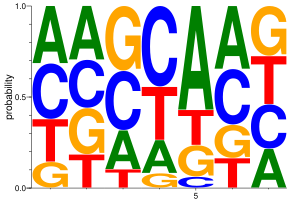

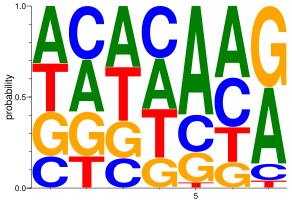

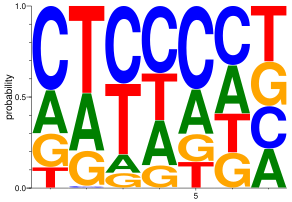

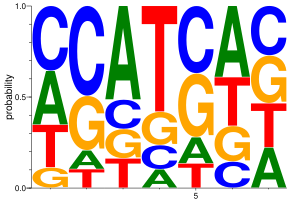

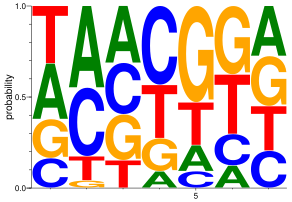

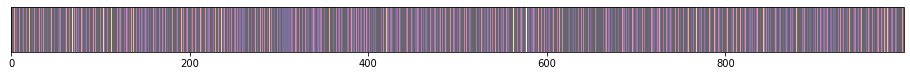

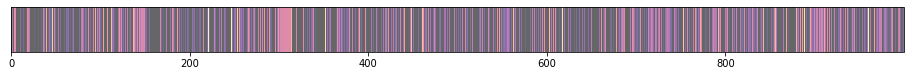

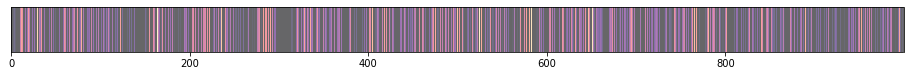

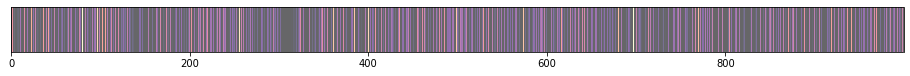

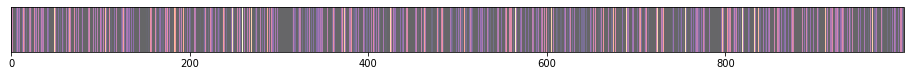

In [62]:
idxs_mif = wgt_filter_acts_avg.topk(5,dim=0)[1]
for i in idxs_mif:
    filter_acts = wgt_filter_acts[i.item()].detach().numpy()
    filter_acts = relu_tensor(filter_acts)
    plot_seq(filter_acts)
    display(plot_PWM(filter_acts))

In [12]:
fwd_handle.remove()
bwd_handle.remove()

In [ ]:
# srcs
# https://arxiv.org/pdf/1610.02391.pdf
# https://medium.com/@stepanulyanin/implementing-grad-cam-in-pytorch-ea0937c31e82
# https://course.fast.ai/videos/?lesson=6
#TODO improve it with guided backpropagation https://arxiv.org/pdf/1412.6806.pdf

# grad cam ++ https://arxiv.org/pdf/1710.11063.pdf
# plot weight of first layer filters http://cs231n.github.io/understanding-cnn/
# plot on the input local high level features separated
# calculate population metrics of certain label with averaging over a set of samples and plot weights of first layer

## loss graphs

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
chpt_lstm = '../data/lightning_logs/version_55/metrics.csv'
chpt_txl  = '../data/lightning_logs/version_51/metrics.csv'

In [32]:
csv = pd.read_csv(chpt_lstm)
csv['created_at'] =  pd.to_datetime(csv['created_at'], format='%Y%m%d %H:%M:%S.%f')
csv['created_at'] =  (csv['created_at'] - csv['created_at'][csv.first_valid_index()]).dt.total_seconds()
csv = csv.set_index('created_at')
csv

,train_loss,epoch,val_loss,valid_roc_auc,valid_acc
created_at,,,,,
0.000000,0.098585,0,NaN,NaN,NaN
0.620962,0.078722,0,NaN,NaN,NaN
1.192734,0.077337,0,NaN,NaN,NaN
1.758596,0.093673,0,NaN,NaN,NaN
2.333053,0.084425,0,NaN,NaN,NaN
...,...,...,...,...,...
90263.430217,0.076333,5,NaN,NaN,NaN
90264.674053,0.066951,5,NaN,NaN,NaN
90265.928700,0.055678,5,NaN,NaN,NaN


In [56]:
def plot_losses(csv_path, ax,avg_win_sz=500,time=False):
    csv = pd.read_csv(csv_path)
    if time:
        csv['created_at'] =  pd.to_datetime(csv['created_at'], format='%Y%m%d %H:%M:%S.%f')
        csv['Seconds'] =  (csv['created_at'] - csv['created_at'][csv.first_valid_index()]).dt.total_seconds()
        csv = csv.set_index('Seconds')

    trn = csv[csv['train_loss'].notnull()]
    trn['train_loss'].rolling(avg_win_sz).mean().plot(ax=ax)
  
    val = csv[csv['val_loss'].notnull()]
    val['val_loss'].plot(ax=ax)

In [57]:
def plot_roc_auc(csv_path,ax,time=False):
    csv = pd.read_csv(csv_path)
    if time:
        csv['created_at'] =  pd.to_datetime(csv['created_at'], format='%Y%m%d %H:%M:%S.%f')
        csv['Seconds'] =  (csv['created_at'] - csv['created_at'][csv.first_valid_index()]).dt.total_seconds()
        csv = csv.set_index('Seconds')
        
    val = csv[csv['val_loss'].notnull()]
    val['valid_roc_auc'].plot(ax=ax)

Text(0.5, 1.0, 'ROC AUC vs time')

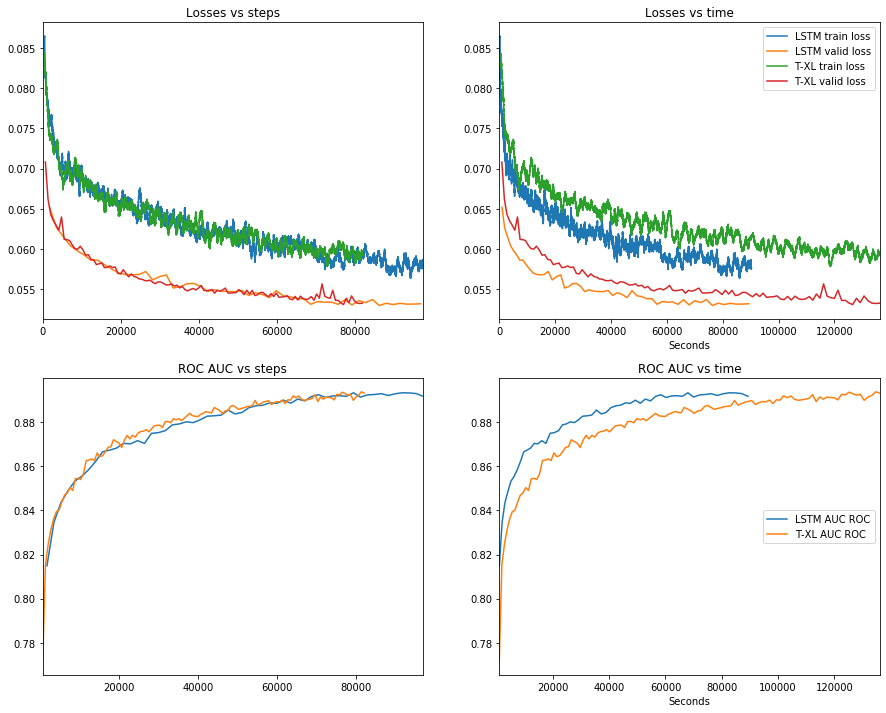

In [60]:
fig, axs = plt.subplots(2,2,figsize=(15,12))

plot_losses(chpt_lstm,axs[0,0])
plot_losses(chpt_txl, axs[0,0])
axs[0,0].set_title('Losses vs steps')

plot_losses(chpt_lstm,axs[0,1],time=True)
plot_losses(chpt_txl, axs[0,1],time=True)
axs[0,1].legend(['LSTM train loss','LSTM valid loss','T-XL train loss','T-XL valid loss'])
axs[0,1].set_title('Losses vs time')

plot_roc_auc(chpt_lstm,axs[1,0])
plot_roc_auc(chpt_txl, axs[1,0])
axs[1,0].set_title('ROC AUC vs steps')

plot_roc_auc(chpt_lstm,axs[1,1],time=True)
plot_roc_auc(chpt_txl, axs[1,1] ,time=True)
plt.legend(['LSTM AUC ROC','T-XL AUC ROC'],loc="center right")
axs[1,1].set_title('ROC AUC vs time')